In [15]:
import numpy as np
import keras
from keras import layers
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from autograd import grad
import theano

## NLM example

This includes some example outputs of running NLM model on different datasts. Most of them should be seen in the main notebook, except the MNIST part.

In [16]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(12, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def NN(data, input_shape, nc, batch_size, epochs, loss):
    # separate data
    x_train, x_test, y_train, y_test = train_test_split(data[['x','y']], data['label'], test_size=0.3, 
                                                        stratify = data['label'], random_state=0)
    x_train = np.array(x_train)
    y_train = np.array(pd.get_dummies(y_train))
    x_test = np.array(x_test)
    y_test = np.array(pd.get_dummies(y_test))
    print("Shape of data: ", x_train.shape,y_train.shape, x_test.shape,y_test.shape)
    # train the model  
    batch_size = batch_size
    epochs = epochs
    
    model = make_model(input_shape=input_shape, num_classes=nc)
    model.compile(loss = loss, optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,verbose=0)
    # evaluation 
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    pred = model.predict(x_test)
    print(pred.shape)
    auc = roc_auc_score(y_test, pred)
    print("AUC: ", auc)
    return model 

def softmax1(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1)[:,None]
def plot_graphs(data,samples,model,xs = [-8,8],ys = [-8,8],aad = [0,0],nc =3):

    #create linespace
    x_linespace = np.linspace(xs[0], xs[1], 100)
    y_linespace = np.linspace(ys[0], ys[1], 100)
    dd_linespace = [[a, b] for a in x_linespace for b in y_linespace] 
    df_linespace = pd.DataFrame(dd_linespace,columns = ['x','y'])

    #construct feature space
    intermediate_layer_model = keras.Model(inputs=model.input,
                                        outputs=model.get_layer(index = 4).output)


    linespace_output = np.array(intermediate_layer_model(df_linespace[['x','y']].values))
    linespace_withc = np.hstack((linespace_output,np.ones((linespace_output.shape[0],1),dtype = linespace_output.dtype)))

    #predict label for each point on linespace
    rand_samples = samples #[:700] #changed depending on sample!!!!!
    all_preds = []
    for W in rand_samples:
        V = softmax1(linespace_withc @ np.array(W).reshape((-1,nc)))
        all_preds.append(V)

    #assign predicted labels
    df_linespace['label'] = np.argmax(np.mean(all_preds,axis = 0),axis = 1)

    #assign uncertainty (using variance)
    mean_label = df_linespace['label']
    varss = np.var(all_preds,axis = 0)
    df_linespace['var']= [varss[i][mean_label[i]] for i in range(len(varss))]
    df_linespace['var'] = [a+aad[1] if a> aad[0] else a for a in df_linespace['var']]
    df_linespace['var'] = df_linespace['var'].fillna(0)
    # mesh grid
    X, Y = np.meshgrid(x_linespace, y_linespace)
    
    plt.figure(figsize = (16,8))
    plt.subplot(1,2,1)
    plottt = df_linespace.pivot("y","x", "label")
    plt.contourf(X,Y,plottt.values)
    df1a = data
    plt.scatter(df1a[df1a['label']==1]['x'],df1a[df1a['label']==1]['y'], color = 'green')
    plt.scatter(df1a[df1a['label']==0]['x'],df1a[df1a['label']==0]['y'], color = 'blue')
    plt.scatter(df1a[df1a['label']==2]['x'],df1a[df1a['label']==2]['y'], color = 'red')
    plt.title('Classifications')
    plt.xlim([xs[0],xs[1]])
    plt.ylim([ys[0],ys[1]])

    plt.subplot(1,2,2)
    plottt = df_linespace.pivot("y","x", "var")
    plt.contourf(X,Y,plottt.values)
    plt.scatter(df1a[df1a['label']==1]['x'],df1a[df1a['label']==1]['y'], color = 'green')
    plt.scatter(df1a[df1a['label']==0]['x'],df1a[df1a['label']==0]['y'], color = 'blue')
    plt.scatter(df1a[df1a['label']==2]['x'],df1a[df1a['label']==2]['y'], color = 'red')
    plt.title('Uncertainty')
    plt.xlim([xs[0],xs[1]])
    plt.ylim([ys[0],ys[1]])
    return linespace_output,plottt.values

1. 

In [17]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 3], [-3, -3], [3, -3]], 
                           cluster_std=0.9, 
                           n_features=2, 
                           random_state=0)

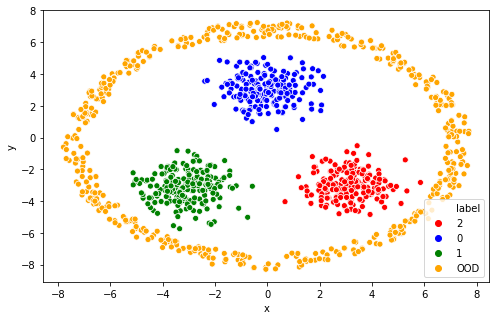

In [18]:
# generate OOD
np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))
df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1a_a = df1a.append(df1a_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1a_a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);


In [19]:
# NN model
model = NN(df1a, 2, 3, 32, 15, "categorical_crossentropy")

Shape of data:  (420, 2) (420, 3) (180, 2) (180, 3)
Test loss: 0.00046736246440559626
Test accuracy: 1.0
(180, 3)
AUC:  1.0


In [20]:
# The last hidden layer ---> index = 2
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(index = 4).output)
# feature map
intermediate_output = np.array(intermediate_layer_model(df1a[['x','y']].values))

$W \sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})$
$$\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right] = \log \left[\mathcal{N}(\mathbf{W}; 0, 5^2 \mathbf{I}) \prod_{n=1}^N softmax(WX^n)[y^n] \right]  = \log \left[  \prod_{n=1}^{D} \frac{1}{\sqrt{2\pi}5} \exp(-\frac{1}{2}(\frac{w_n}{5})^2) * \prod_{n=1}^N softmax(WX^n)[y^n]\right]  = \sum_{n=1}^{N} \log{(softmax(WX^n)[y^n])} + D* \log{\frac{1}{\sqrt{2\pi}5}} +(-\frac{1}{50} \sum_{n=1}^{D} w_n^2)$$

In [21]:
# pymc sampler
import autograd.numpy as np
import pymc3 as pm
import theano.tensor as T
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
nc = 3 # 3 classes
D = nc * (intermediate_output.shape[1] + 1) 
x = intermediate_output
y = df1a['label'].values
Priord = 1
x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))
with pm.Model() as bayesian_model:
    #define priors
    W = pm.Normal('W', mu=0, tau=1./(Priord**2), shape= D)
    
    p = pm.math.dot(x_with_constant, W.reshape((-1,nc))) 
    
    #softmax
    theta = T.nnet.softmax(p)
    #define binomial likelihood
    y_obs = pm.Categorical('y_obs',  p=theta, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(5000,step,tune = 10000,chains = 2)
thinned_trace = trace[::1]['W']

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:18<00:00, 1617.29draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


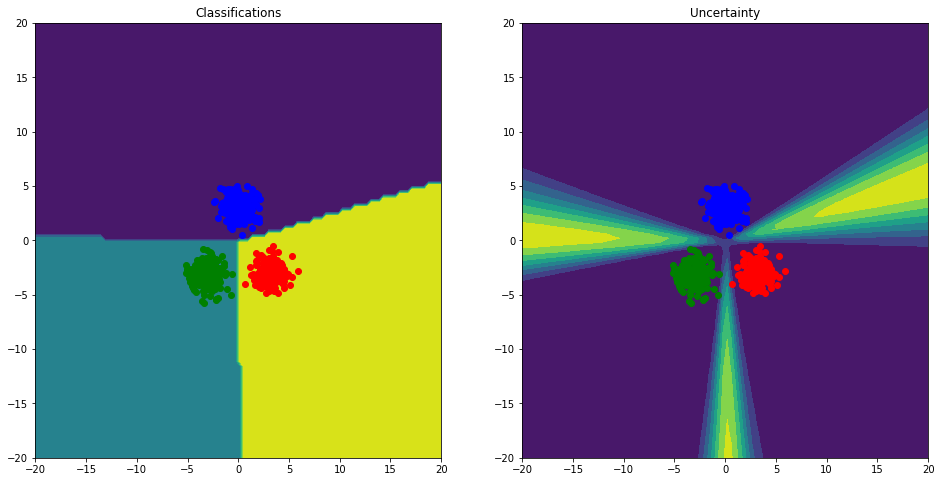

In [22]:
_,pp = plot_graphs(df1a,thinned_trace,model,[-20,20],[-20,20])

2. 

In [72]:
# generate OOD
np.random.seed(0)
r = 6 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

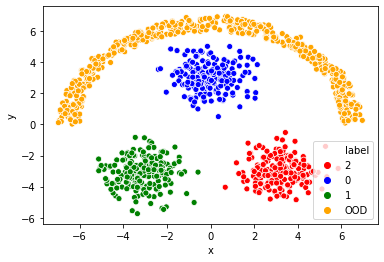

In [73]:
df1b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1b_a = df1b.append(df1b_ood, ignore_index=True)

sns.scatterplot(data=df1b_a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

In [74]:
model = NN(df1b, 2, 3, 32, 15, "categorical_crossentropy")

Shape of data:  (420, 2) (420, 3) (180, 2) (180, 3)
Test loss: 0.0005183872417546809
Test accuracy: 1.0
(180, 3)
AUC:  1.0


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:11<00:00, 2670.52draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


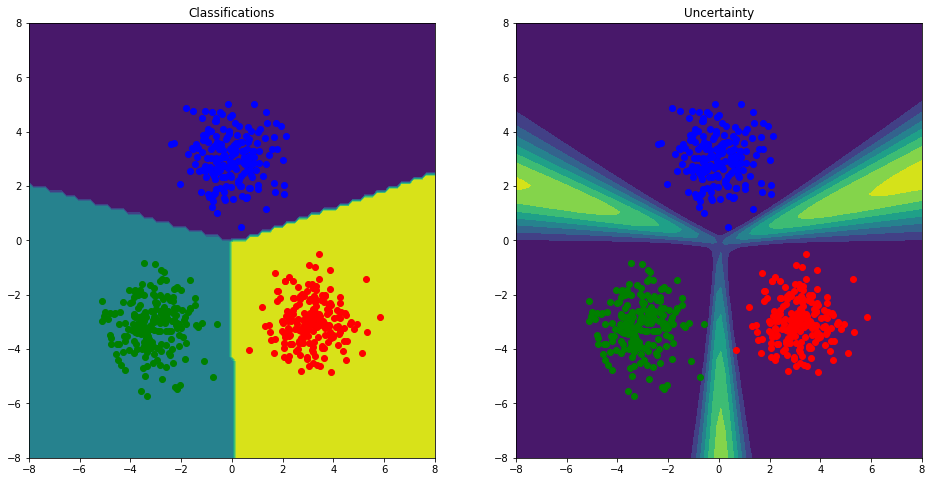

In [75]:
# The last hidden layer ---> index = 2
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(index = 4).output)
# feature map
intermediate_output = np.array(intermediate_layer_model(df1b[['x','y']].values))

# pymc sampler
import autograd.numpy as np
import pymc3 as pm
import theano.tensor as T
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
nc = 3 # 3 classes
D = nc * (intermediate_output.shape[1] + 1) 
x = intermediate_output
y = df1b['label'].values
Priord = 1
x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))
with pm.Model() as bayesian_model:
    #define priors
    W = pm.Normal('W', mu=0, tau=1./(Priord**2), shape= D)
    
    p = pm.math.dot(x_with_constant, W.reshape((-1,nc))) 
    
    #softmax
    theta = T.nnet.softmax(p)
    #define binomial likelihood
    y_obs = pm.Categorical('y_obs',  p=theta, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(5000,step,tune = 10000,chains = 2)
thinned_trace = trace[::1]['W']
_,pp = plot_graphs(df1b,thinned_trace,model)

3. 

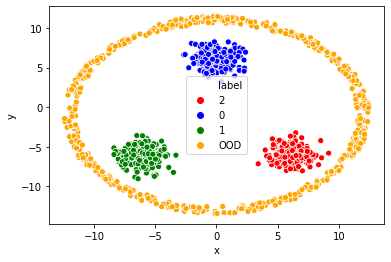

In [76]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 6], [-6, -6], [6, -6]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

# generate OOD
np.random.seed(0)
r = 11.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-1+(r + random.random())*np.sin(angle))
df2a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2a_a = df2a.append(df2a_ood, ignore_index=True)

sns.scatterplot(data=df2a_a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

In [77]:
model = NN(df2a, 2, 3, 32, 15, "categorical_crossentropy")

Shape of data:  (420, 2) (420, 3) (180, 2) (180, 3)
Test loss: 0.0004599176754709333
Test accuracy: 1.0
(180, 3)
AUC:  1.0


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:13<00:00, 2280.04draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


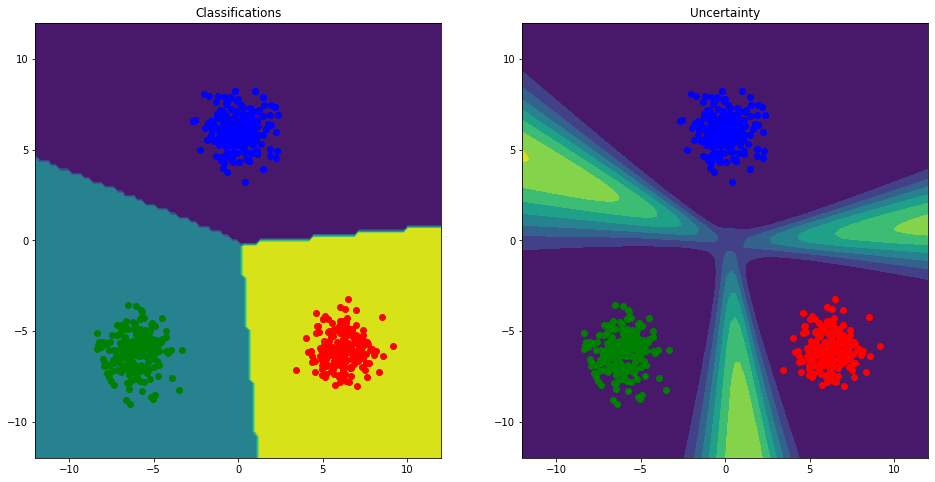

In [78]:
# The last hidden layer ---> index = 2
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(index = 4).output)
# feature map
intermediate_output = np.array(intermediate_layer_model(df2a[['x','y']].values))

# pymc sampler
import autograd.numpy as np
import pymc3 as pm
import theano.tensor as T
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
nc = 3 # 3 classes
D = nc * (intermediate_output.shape[1] + 1) 
x = intermediate_output
y = df2a['label'].values
Priord = 1
x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))
with pm.Model() as bayesian_model:
    #define priors
    W = pm.Normal('W', mu=0, tau=1./(Priord**2), shape= D)
    
    p = pm.math.dot(x_with_constant, W.reshape((-1,nc))) 
    
    #softmax
    theta = T.nnet.softmax(p)
    #define binomial likelihood
    y_obs = pm.Categorical('y_obs',  p=theta, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(5000,step,tune = 10000,chains = 2)
thinned_trace = trace[::1]['W']
_,pp = plot_graphs(df2a,thinned_trace,model,[-12,12],[-12,12])

4. three boudary data

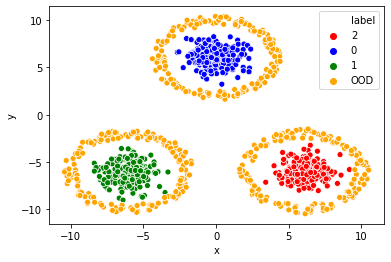

In [79]:
# generate OOD
np.random.seed(42)
r = 3.5 # radius
cx1, cx2, cx3 = 0, -6, 6
cy1, cy2, cy3 = 6, -6, -6
x1, x2 = [], []
for _ in range(500//3):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(cx1 + (r + random.random())*np.cos(angle))
    x1.append(cx2 + (r + random.random())*np.cos(angle))
    x1.append(cx3 + (r + random.random())*np.cos(angle))
    x2.append(cy1 + (r + random.random())*np.sin(angle))
    x2.append(cy2 + (r + random.random())*np.sin(angle))
    x2.append(cy3 + (r + random.random())*np.sin(angle))
df2b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2b_a = df2b.append(df2b_ood, ignore_index=True)

sns.scatterplot(data=df2b_a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

In [80]:
model = NN(df2b, 2, 3, 32, 15, "categorical_crossentropy")

Shape of data:  (420, 2) (420, 3) (180, 2) (180, 3)
Test loss: 0.0002240127942059189
Test accuracy: 1.0
(180, 3)
AUC:  1.0


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:14<00:00, 2052.26draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


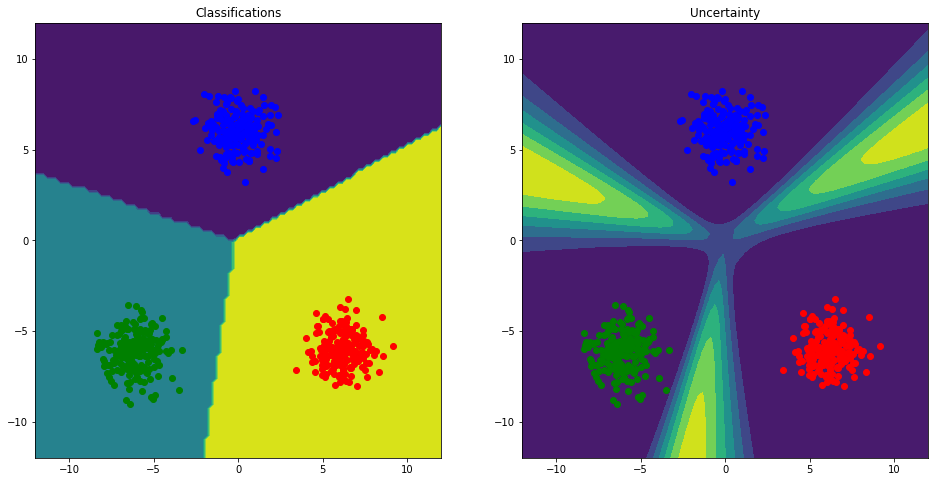

In [81]:
# The last hidden layer ---> index = 2
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(index = 4).output)
# feature map
intermediate_output = np.array(intermediate_layer_model(df2b[['x','y']].values))

# pymc sampler
import autograd.numpy as np
import pymc3 as pm
import theano.tensor as T
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
nc = 3 # 3 classes
D = nc * (intermediate_output.shape[1] + 1) 
x = intermediate_output
y = df2b['label'].values
Priord = 1
x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))
with pm.Model() as bayesian_model:
    #define priors
    W = pm.Normal('W', mu=0, tau=1./(Priord**2), shape= D)
    
    p = pm.math.dot(x_with_constant, W.reshape((-1,nc))) 
    
    #softmax
    theta = T.nnet.softmax(p)
    #define binomial likelihood
    y_obs = pm.Categorical('y_obs',  p=theta, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(5000,step,tune = 10000,chains = 2)
thinned_trace = trace[::1]['W']
_,pp = plot_graphs(df2b,thinned_trace,model,[-12,12],[-12,12])

5. 

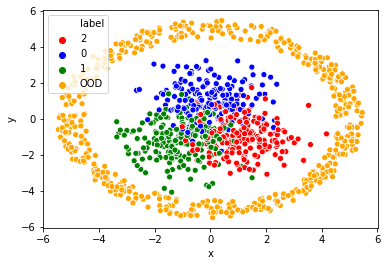

In [82]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 1], [-1, -1], [1, -1]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)
# generate OOD
np.random.seed(42)
r = 4.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

df3 = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df3_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df3_a = df3.append(df3_ood, ignore_index=True)

sns.scatterplot(data=df3_a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

In [83]:
model = NN(df3, 2, 3, 32, 15, "categorical_crossentropy")

Shape of data:  (420, 2) (420, 3) (180, 2) (180, 3)
Test loss: 0.43856096267700195
Test accuracy: 0.8222222328186035
(180, 3)
AUC:  0.9504166666666666


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:19<00:00, 1570.05draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


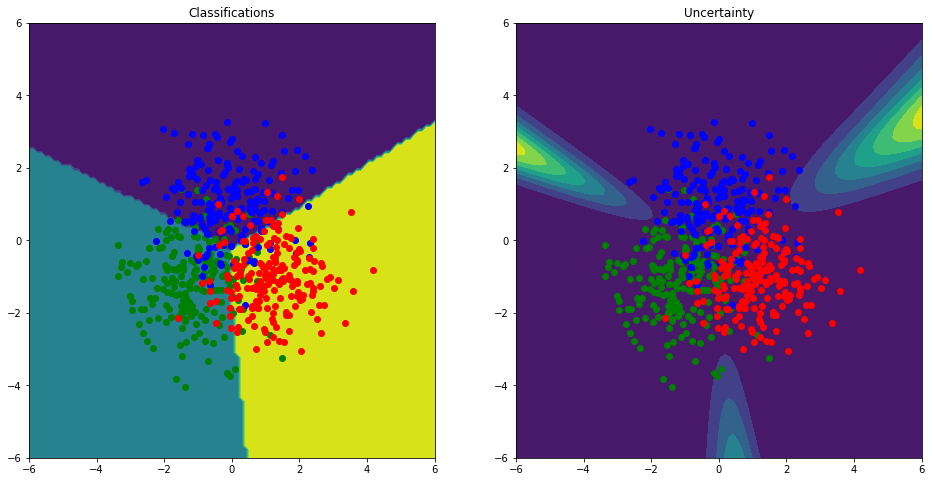

In [84]:
# The last hidden layer ---> index = 2
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(index = 4).output)
# feature map
intermediate_output = np.array(intermediate_layer_model(df3[['x','y']].values))

# pymc sampler
import autograd.numpy as np
import pymc3 as pm
import theano.tensor as T
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
nc = 3 # 3 classes
D = nc * (intermediate_output.shape[1] + 1) 
x = intermediate_output
y = df3['label'].values
Priord = 1
x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))
with pm.Model() as bayesian_model:
    #define priors
    W = pm.Normal('W', mu=0, tau=1./(Priord**2), shape= D)
    
    p = pm.math.dot(x_with_constant, W.reshape((-1,nc))) 
    
    #softmax
    theta = T.nnet.softmax(p)
    #define binomial likelihood
    y_obs = pm.Categorical('y_obs',  p=theta, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(5000,step,tune = 10000,chains = 2)
thinned_trace = trace[::1]['W']
_,pp = plot_graphs(df3,thinned_trace,model,[-6,6],[-6,6])

6. 

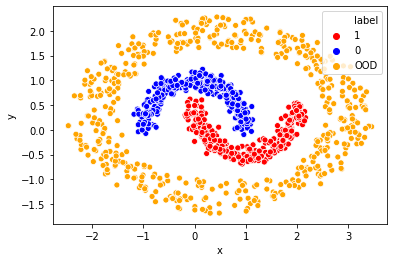

In [48]:
X, y = datasets.make_moons(n_samples=600, shuffle=True, noise=0.1, random_state=0)
# generate OOD
np.random.seed(0)
r = 2 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(.5+(r + random.random())*np.cos(angle))
    x2.append(.3+(r + random.random())/1.5*np.sin(angle))
df4 = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df4_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df4_a = df4.append(df4_ood, ignore_index=True)

sns.scatterplot(data=df4_a, x="x", y="y", hue="label", palette=["red", "blue", "orange"]);

In [53]:
model = NN(df4, 2, 2, 32, 15, "categorical_crossentropy")

Shape of data:  (420, 2) (420, 2) (180, 2) (180, 2)
Test loss: 0.12219973653554916
Test accuracy: 0.9555555582046509
(180, 2)
AUC:  0.9944444444444445


Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:09<00:00, 3058.45draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


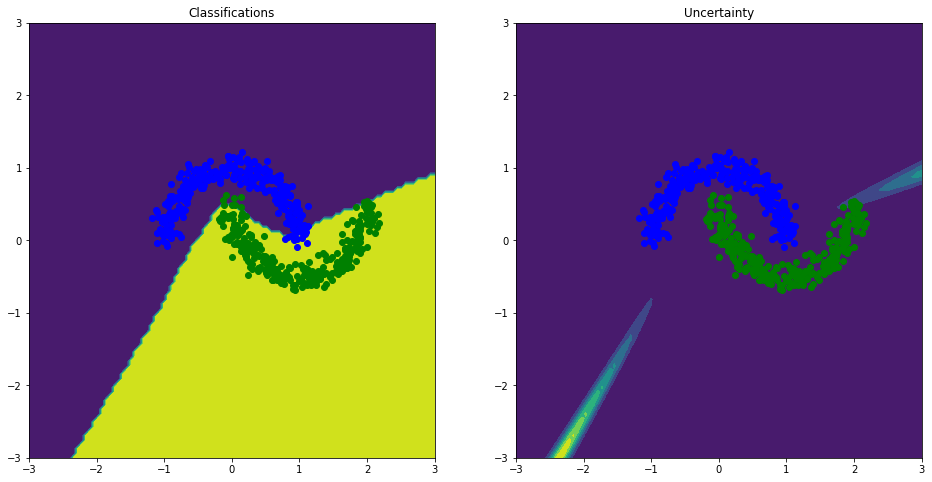

In [61]:
# The last hidden layer ---> index = 4
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(index = 4).output)
# feature map
intermediate_output = np.array(intermediate_layer_model(df4[['x','y']].values))

# pymc sampler
import autograd.numpy as np
import pymc3 as pm
import theano.tensor as T
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
nc = 2 # 2 classes
D = nc * (intermediate_output.shape[1] + 1) 
x = intermediate_output
y = df4['label'].values
Priord = 1
x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))
with pm.Model() as bayesian_model:
    #define priors
    W = pm.Normal('W', mu=0, tau=1./(Priord**2), shape= D)
    
    p = pm.math.dot(x_with_constant, W.reshape((-1,nc))) 
    
    #softmax
    theta = T.nnet.softmax(p)
    #define binomial likelihood
    y_obs = pm.Categorical('y_obs',  p=theta, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(5000,step,tune = 10000,chains = 2)
thinned_trace = trace[::1]['W']
_,pp = plot_graphs(df4,thinned_trace,model,[-3,3],[-3,3],nc=2)

7 MNIST

In [23]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

# Pick out 3 classes of digits: 0, 1, 2 and take a subset of samples as in-distribution points
X_0, y_0 = X[(y == '0')][:500], y[(y == '0')][:500].astype(int)
X_1, y_1 = X[(y == '1')][:500], y[(y == '1')][:500].astype(int)
X_2, y_2 = X[(y == '2')][:500], y[(y == '2')][:500].astype(int)

X_ood, y_ood = X[(y == '3')][:500], ['OOD'] * 500
# combine data
X_mnist = np.concatenate((X_0, X_1, X_2))
y_mnist = np.concatenate((y_0, y_1, y_2))

In [24]:
def MNIST_NN(X,Y, input_shape, nc, batch_size, epochs, loss):
    # separate data
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, 
                                                        stratify = Y, random_state=0)
    x_train = np.array(x_train)
    y_train = np.array(pd.get_dummies(y_train))
    x_test = np.array(x_test)
    y_test = np.array(pd.get_dummies(y_test))
    print("Shape of data: ", x_train.shape,y_train.shape, x_test.shape,y_test.shape)
    # train the model  
    batch_size = batch_size
    epochs = epochs
    
    model = make_model(input_shape=input_shape, num_classes=nc)
    model.compile(loss = loss, optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,verbose=0)
    # evaluation 
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    pred = model.predict(x_test)
    print(pred.shape)
    auc = roc_auc_score(y_test, pred)
    print("AUC: ", auc)
    return model 
model = MNIST_NN(X_mnist,y_mnist, 784, 3, 32, 15,  "categorical_crossentropy")
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(index = 4).output)

intermediate_output = np.array(intermediate_layer_model(np.array(X_mnist)))

Shape of data:  (1050, 784) (1050, 3) (450, 784) (450, 3)
Test loss: 0.49344223737716675
Test accuracy: 0.9800000190734863
(450, 3)
AUC:  0.9968074074074074


In [25]:
intermediate_output.shape

(1500, 12)

In [26]:
# pymc sampler
import autograd.numpy as np
import pymc3 as pm
import theano.tensor as T
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
nc = 3 # 3 classes
D = nc * (intermediate_output.shape[1] + 1) 
x = intermediate_output
y = np.array(y_mnist)
Priord = 1
x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))
with pm.Model() as bayesian_model:
    #define priors
    W = pm.Normal('W', mu=0, tau=1./(Priord**2), shape= D)
    
    p = pm.math.dot(x_with_constant, W.reshape((-1,nc))) 
    
    #softmax
    theta = T.nnet.softmax(p)
    #define binomial likelihood
    y_obs = pm.Categorical('y_obs',  p=theta, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(5000,step,tune = 10000,chains = 2)
thinned_trace = trace[::1]['W']

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [W]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:24<00:00, 1207.07draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [32]:
# NN Prediction for in-distribution and ood data
intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(index = 4).output)

output_in = np.array(intermediate_layer_model(np.array(X_mnist)))
output_ood = np.array(intermediate_layer_model(np.array(X_ood)))
in_withc = np.hstack((output_in,np.ones((output_in.shape[0],1),dtype = output_in.dtype)))
ood_withc = np.hstack((output_ood,np.ones((output_ood.shape[0],1),dtype = output_ood.dtype)))

#calculate uncertainty(using variance)
rand_samples = thinned_trace #[:700] #changed depending on sample!!!!!
all_preds_in = []
all_preds_ood = []
for W in rand_samples:
    all_preds_in.append(softmax1(in_withc @ np.array(W).reshape((-1,nc))))
    all_preds_ood.append(softmax1(ood_withc @ np.array(W).reshape((-1,nc))))
#assign predicted labels
mean_label_in = np.argmax(np.mean(all_preds_in,axis = 0),axis = 1)
mean_label_ood = np.argmax(np.mean(all_preds_ood,axis = 0),axis = 1)

#assign uncertainty (using variance)
varss_in = np.var(all_preds_in,axis = 0)
var_in= np.mean([varss_in[i][mean_label_in[i]] for i in range(len(varss_in))])

varss_ood = np.var(all_preds_ood,axis = 0)
var_ood= np.mean([varss_ood[i][mean_label_ood[i]] for i in range(len(varss_ood))])  

print("Uncertainty for in distribution data is ",var_in)
print("Uncertainty for ood data is ", var_ood)

Uncertainty for in distribution data is  0.0009065718152854499
Uncertainty for ood data is  0.012501108017907565


In [ ]:
# # HMC to calculate the posterior
# import autograd.numpy as np
# nc = 3 # 3 classes
# D = nc * (intermediate_output.shape[1] + 1) 
# x = intermediate_output
# y = df1a['label'].values
# N = x.shape[0]
# Priord = 10
# x_with_constant = np.hstack((x, np.ones((x.shape[0], 1), dtype=x.dtype)))

# def log_posterior(W):

#     V_ = softmax1(x_with_constant @ np.array(W).reshape((-1,nc)))
#     term1 = sum([np.log(V_[i][int(y[i])]) for i in range(N)])
#     term2 = D* np.log(1/(Priord*np.sqrt(2*np.pi))) -(1/Priord**2/2)*np.sum(W**2)
#     return term1 + term2 

# # The code is from class exercise 10.20

# D = D #dim
# m = 1 #mass
# M = m * np.eye(D) #mass matrix

# def U(W):
#     return -log_posterior(W)
 
# du_dy = grad(U) #gradient of U wrt to y

# def K(p):
#   # kinetic energy function
#   return 0.5 * p.T @ np.linalg.inv(M) @ p + 0.5 * np.log(np.linalg.det(M)) + 0.5 * D * np.log(2 * np.pi)
# dK_dp = grad(K) #gradient of K wrt p

# def H(y, p):
#   # H(y, p) = U(y) + K(p)
#   return U(y) + K(p)

# def HMC(y_init, num_samples, num_steps, epsilon, burnin, thinning):
#   # initialization
#     samples = [y_init]
#     y_current = y_init
#     accept = 0
#     for s in range(num_samples):
#         # sample a random momentum from the Gibbs distribution of K(p), here is N(0,M)
#         p_current = np.random.multivariate_normal(mean=np.zeros(D),cov=M)
        
#         # leap-frog integrator
#         y_next = y_current
#         p_next = p_current
#         p_next -= 0.5 * epsilon * np.array(du_dy(y_next)) #half-step update for momentum p 
#         for j in range(int(num_steps)):
#             y_next += epsilon * dK_dp(p_next) #full-step update for position y
#             p_next -= epsilon * du_dy(y_next) #full-step update for momentum p 
#         y_next += epsilon * dK_dp(p_next) #full-step update for position y
#         p_next -= 0.5 * epsilon * du_dy(y_next) #half-step update for momentum p 

#         # reverse momentum
#         p_next = -p_next

#         # correction for simulation error
#         alpha = min(1, np.exp(H(y_current, p_current) - H(y_next, p_next)))
#         if np.random.uniform(0, 1) <= alpha:
#             y_current, p_current = y_next, p_next
#             accept += 1
#         samples.append(list(y_current))

#     # burnin and thinning:
#     samples = samples[burnin::thinning]
#     return samples, accept/num_samples

# y_init =np.array(list(model.layers[5].get_weights()[0][:,:nc].flatten())+list(model.layers[5].get_weights()[1][:nc].flatten()))
# #y_init = np.ones((1,27)).flatten()
# num_samples = 800
# num_steps = 50
# epsilon = 1e-3 
# burnin = 100
# thinning = 1


# samples, accept = HMC(y_init, num_samples, num_steps, epsilon, burnin, thinning)